In [1]:
import numpy as np
import pylops
import dxchange
from glob import glob
from matplotlib import pyplot as plt

import imwip

Load data

In [2]:
path = "/media/jens/Samsung_T5/Umberto/"
files = sorted(glob(path + "TIF for 3DCAFM/H10121_*"), key=lambda x: int(x.split("/")[-1].split("_")[2]))
original = []
for file in files:
    original.append(dxchange.read_tiff(file))
original = np.array(original, dtype=np.float32)/(2**16 - 1)

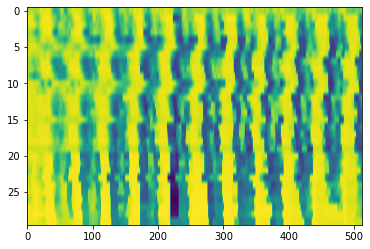

In [3]:
plt.imshow(original[:, :, original.shape[2]//2], aspect="auto")

Call the original 3D image $x$, which is a stack of misaligned slices:

$x = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
$

We are looking for a vector $t$ of translation parameters such that

$
M(t)x=\begin{bmatrix}
T(t_1) & 0 & \cdots & 0 \\
0 & T(t_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & T(t_n)
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix}
$

is better aligned.

A suitible objective function is the vertical total variation, i.e. the norm image gradient in the vertical direction:

$f(t) = \frac{1}{2} \lVert \nabla_z M(t)x\rVert^2$

In [4]:
x = original.ravel()
im_shape = original.shape[1:]
T = lambda ti: imwip.AffineWarpingOperator2D(im_shape, translation=ti)
M = lambda t: pylops.BlockDiag([T(ti) for ti in t.reshape(-1, 2)])
D = imwip.GradientOperator3DX(original.shape)

In [5]:
def f(t):
    DMx = D @ M(t) @ x
    return 1/2 * np.dot(DMx, DMx)

More important for the solver is the gradient of this objective function:

$\nabla f(t) = \left(\frac{d}{dt}M(t)x\right)^T\nabla_z^T(\nabla_z M(t)x)$

In [6]:
def grad_f(t):
    DMx = D @ M(t) @ x
    return imwip.diff(M(t), x, to="translation").T @ (D.T @ DMx)

In [7]:
t0 = np.zeros(original.shape[0]*2)
t = imwip.barzilai_borwein(grad_f, x0=t0, max_iter=30, verbose=True)
rec = (M(t) @ x).reshape(original.shape)

100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.61it/s]


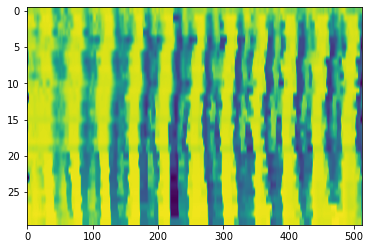

In [8]:
plt.imshow(np.clip(rec[:, :, rec.shape[2]//2], 0, 1), aspect="auto")

Local minima can be avoided by repeating the optimization at multiple resolutions

In [9]:
from skimage.transform import downscale_local_mean

t = np.zeros(original.shape[0]*2)
for factor, iters in [(8, 200), (4, 150), (2, 30), (1, 30)]:
    scaled = downscale_local_mean(original, (1, factor, factor))
    x = scaled.ravel()
    im_shape = scaled[0].shape
    D = imwip.GradientOperator3DX(scaled.shape)
    t = imwip.barzilai_borwein(grad_f, x0=t*2, max_iter=iters, verbose=True)
rec = (M(t) @ x).reshape(original.shape)

100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


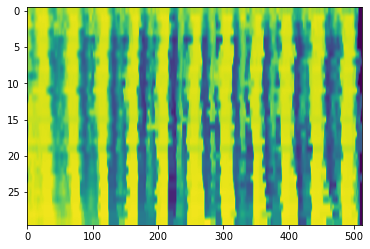

In [10]:
plt.imshow(np.clip(rec[:, :, rec.shape[2]//2], 0, 1), aspect="auto")